In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional # type: ignore
from tensorflow.keras.layers import Embedding # type: ignore

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
df = pd.read_csv('../Dataset/news.csv')
df

,label,text
0,0,change expected espn political agenda despite ...
1,0,bobby jindal raised hindu us story christian c...
2,0,seek humanitarian pause sanaa street battlegro...
3,1,unbelievable obama attorney general say charlo...
4,0,trump say brexit great thing want quick trade ...
...,...,...
63117,0,unlikely contender rise france antithesis trum...
63118,1,chelsea clinton confronted woman book signing ...
63119,1,florida judge blame rape victim attending musi...
63120,0,determined kill tough gun law end mass shootin...


In [3]:
df['text'] = df['text'].astype(str)

In [4]:
# Step 1: Split the data into training and remaining (validation + test)
X_train, temp_data, y_train, temp_labels = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

# Step 2: Split the remaining into validation and test
X_val, X_test, y_val, y_test = train_test_split(temp_data, temp_labels, test_size=0.5, random_state=42)


In [5]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

In [6]:
X_train_tfidf = X_train_tfidf.toarray().reshape((X_train_tfidf.shape[0], 1, X_train_tfidf.shape[1]))
X_test_tfidf = X_test_tfidf.toarray().reshape((X_test_tfidf.shape[0], 1, X_test_tfidf.shape[1]))
X_val_tfidf = X_val_tfidf.toarray().reshape((X_val_tfidf.shape[0], 1, X_val_tfidf.shape[1]))

In [25]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(1, 10000)),
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.LSTM(128), 
    tf.keras.layers.Dense(64, activation='relu'),  
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dropout(0.3),  
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 1, 256)         │    10,503,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,710,657 (40.86 MB)

 Trainable params: 10,710,657 (40.86 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)


model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

history = model.fit(
    X_train_tfidf,
    y_train,
    epochs=300,
    validation_data=(X_val_tfidf, y_val),
    batch_size=64,
    shuffle=True,
    callbacks=[early_stop, lr_scheduler]
    )

Epoch 1/300
790/790 ━━━━━━━━━━━━━━━━━━━━ 42s 51ms/step - accuracy: 0.5535 - loss: 0.6885 - val_accuracy: 0.5562 - val_loss: 0.6803 - learning_rate: 1.0000e-04
Epoch 2/300
790/790 ━━━━━━━━━━━━━━━━━━━━ 40s 50ms/step - accuracy: 0.6070 - loss: 0.6355 - val_accuracy: 0.8877 - val_loss: 0.2827 - learning_rate: 1.0000e-04
Epoch 3/300
790/790 ━━━━━━━━━━━━━━━━━━━━ 40s 50ms/step - accuracy: 0.9184 - loss: 0.2173 - val_accuracy: 0.9406 - val_loss: 0.1601 - learning_rate: 1.0000e-04
Epoch 4/300
790/790 ━━━━━━━━━━━━━━━━━━━━ 40s 50ms/step - accuracy: 0.9538 - loss: 0.1275 - val_accuracy: 0.9487 - val_loss: 0.1427 - learning_rate: 1.0000e-04
Epoch 5/300
790/790 ━━━━━━━━━━━━━━━━━━━━ 40s 50ms/step - accuracy: 0.9652 - loss: 0.0976 - val_accuracy: 0.9504 - val_loss: 0.1360 - learning_rate: 1.0000e-04
Epoch 6/300
790/790 ━━━━━━━━━━━━━━━━━━━━ 40s 50ms/step - accuracy: 0.9705 - loss: 0.0856 - val_accuracy: 0.9507 - val_loss: 0.1384 - learning_rate: 1.0000e-04
Epoch 7/300
790/790 ━━━━━━━━━━━━━━━━━━━━ 40s 5

KeyboardInterrupt: 

In [27]:
best_epoch = early_stop.stopped_epoch - early_stop.patience + 1  # Best epoch where training stopped
print(f"Best epoch: {best_epoch}")

Best epoch: -9


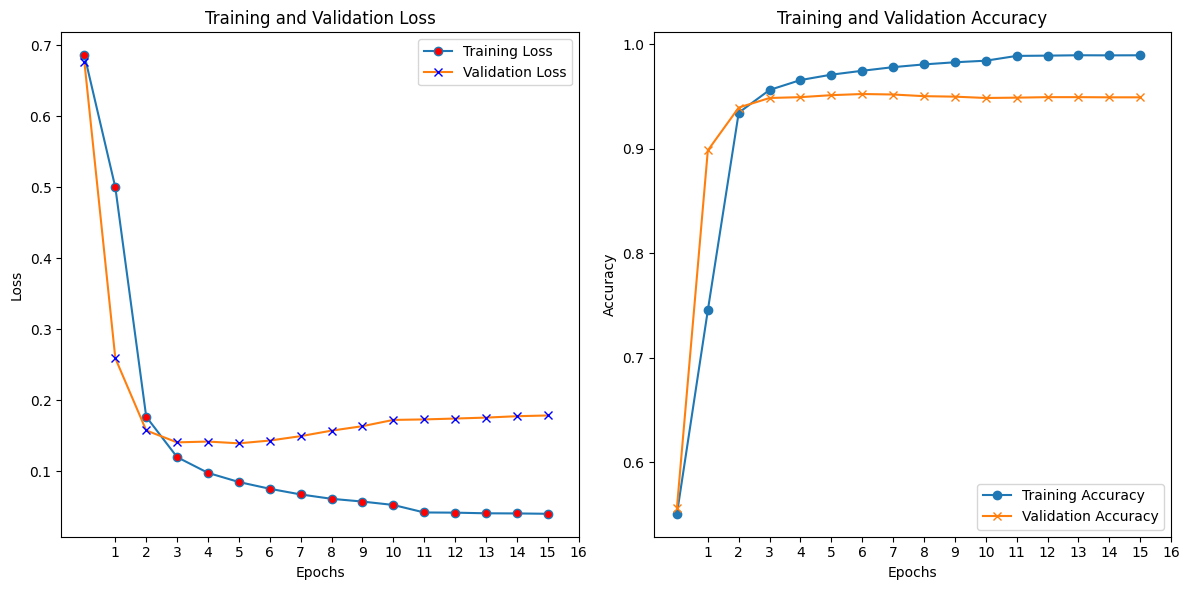

In [23]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], marker='o', markerfacecolor='red', label='Training Loss')
plt.plot(history.history['val_loss'], marker='x', markeredgecolor='blue', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(range(1, len(history.history['loss']) + 1))

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], marker='o', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], marker='x', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(range(1, len(history.history['loss']) + 1))

plt.tight_layout()
plt.show()

In [24]:
model.evaluate(X_test_tfidf, y_test)

198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9499 - loss: 0.1282


[0.12502633035182953, 0.9520037770271301]

In [30]:
pred = model.predict(X_test_tfidf)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

bin = pd.DataFrame(binary_predictions)
bin

198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


,0
0,1
1,1
2,1
3,0
4,0
...,...
6308,1
6309,0
6310,1
6311,0


In [31]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))
print('F1-Score on testing set:', f1_score(binary_predictions, y_test))

Accuracy on testing set: 0.9501029621416125
Precision on testing set: 0.9492063492063492
Recall on testing set: 0.940251572327044
F1-Score on testing set: 0.9447077409162717


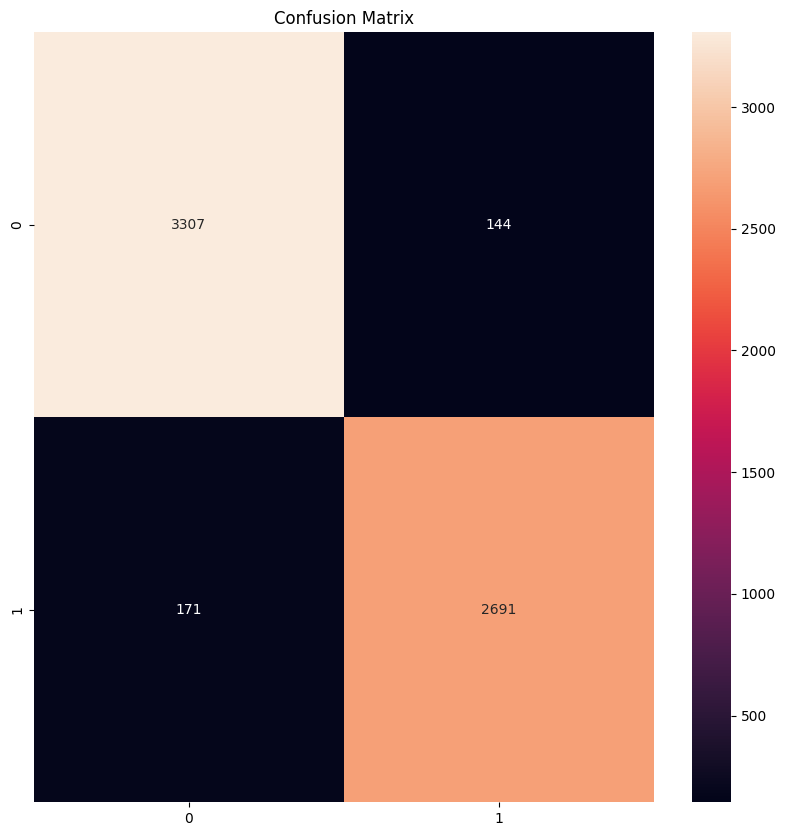

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_test = confusion_matrix(y_test, binary_predictions)

# Display the test confusion matrix
fig, ax = plt.subplots(figsize=(6, 5))  # Adjust the figure size as needed

disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=[0, 1])  # Adjust labels if needed
disp_test.plot(ax=ax, cmap='Blues')
ax.set_title('Test Confusion Matrix')

plt.tight_layout()
plt.show()

In [33]:
import joblib

joblib.dump(tfidf_vectorizer, 'best.pkl')

['best.pkl']

In [34]:
model.save('best.keras')

BiLSTM: 80:10:10

accuracy: 0.9416 - loss: 0.1583 (best, better than old LSTM model)
System RAM: 6.2GB
GPU: 2.2GB

BiLSTM: 70:10:20

accuracy: 0.9396 - loss: 0.1685
System RAM: 6.4GB
GPU: 2.2GB

BiLSTM: 70:10:10

accuracy: 0.9399 - loss: 0.1639
System RAM: 6.4GB
GPU: 2.2GB